In [1]:
from __future__ import absolute_import
import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import Layer
from keras.engine import InputSpec
from keras.legacy import interfaces
from keras.layers import RNN
from keras.layers.recurrent import _generate_dropout_mask
from keras.layers import LSTMCell, LSTM

Using TensorFlow backend.
d:\ProgramData\Anaconda3\envs\keras2.1.3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\ProgramData\Anaconda3\envs\keras2.1.3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\ProgramData\Anaconda3\envs\keras2.1.3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\ProgramData\Anaconda3\envs\ke

In [2]:
class NestedLSTMCell(Layer):
    """Nested NestedLSTM Cell class.
    Derived from the paper [Nested LSTMs](https://arxiv.org/abs/1801.10308)
    Ref: [Tensorflow implementation](https://github.com/hannw/nlstm)
    # Arguments
        units: Positive integer, dimensionality of the output space.
        depth: Depth of nesting of the memory component.
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
        cell_activation: Activation function of the first cell gate.
            Note that in the paper only the first cell_activation is identity.
            (see [activations](../activations.md)).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.](http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf)
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, must be 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units, depth,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 cell_activation='linear',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=False,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(NestedLSTMCell, self).__init__(**kwargs)

        if depth < 1:
            raise ValueError("`depth` must be at least 1. For better performance, consider using depth > 1.")

        if implementation != 1:
            warnings.warn(
                "Nested LSTMs only supports implementation 2 for the moment. Defaulting to implementation = 2")
            implementation = 2

        self.units = units
        self.depth = depth
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.cell_activation = activations.get(cell_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = tuple([self.units] * (self.depth + 1))
        self._dropout_mask = None
        self._nested_recurrent_masks = None

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernels = []
        self.biases = []

        for i in range(self.depth):
            if i == 0:
                input_kernel = self.add_weight(shape=(input_dim, self.units * 4),
                                               name='input_kernel_%d' % (i + 1),
                                               initializer=self.kernel_initializer,
                                               regularizer=self.kernel_regularizer,
                                               constraint=self.kernel_constraint)
                hidden_kernel = self.add_weight(shape=(self.units, self.units * 4),
                                                name='kernel_%d' % (i + 1),
                                                initializer=self.recurrent_initializer,
                                                regularizer=self.recurrent_regularizer,
                                                constraint=self.recurrent_constraint)
                kernel = K.concatenate([input_kernel, hidden_kernel], axis=0)
            else:
                kernel = self.add_weight(shape=(self.units * 2, self.units * 4),
                                         name='kernel_%d' % (i + 1),
                                         initializer=self.recurrent_initializer,
                                         regularizer=self.recurrent_regularizer,
                                         constraint=self.recurrent_constraint)
            self.kernels.append(kernel)

        if self.use_bias:
            if self.unit_forget_bias:
                def bias_initializer(_, *args, **kwargs):
                    return K.concatenate([
                        self.bias_initializer((self.units,), *args, **kwargs),
                        initializers.Ones()((self.units,), *args, **kwargs),
                        self.bias_initializer((self.units * 2,), *args, **kwargs),
                    ])
            else:
                bias_initializer = self.bias_initializer

            for i in range(self.depth):
                bias = self.add_weight(shape=(self.units * 4,),
                                       name='bias_%d' % (i + 1),
                                       initializer=bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       constraint=self.bias_constraint)
                self.biases.append(bias)
        else:
            self.biases = None

        self.built = True

    def call(self, inputs, states, training=None):
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=1)
        if (0 < self.recurrent_dropout < 1 and
                self._nested_recurrent_masks is None):
            _nested_recurrent_mask = _generate_dropout_mask(
                K.ones_like(states[0]),
                self.recurrent_dropout,
                training=training,
                count=self.depth)
            self._nested_recurrent_masks = _nested_recurrent_mask

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_masks = self._nested_recurrent_masks

        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1:self.depth + 1]  # previous carry states

        if 0. < self.dropout < 1.:
            inputs *= dp_mask[0]

        h, c = self.nested_recurrence(inputs,
                                      hidden_state=h_tm1,
                                      cell_states=c_tm1,
                                      recurrent_masks=rec_dp_masks,
                                      current_depth=0)

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        return h, c

    def nested_recurrence(self, inputs, hidden_state, cell_states, recurrent_masks, current_depth):
        h_state = hidden_state
        c_state = cell_states[current_depth]

        if 0.0 < self.recurrent_dropout <= 1. and recurrent_masks is not None:
            hidden_state = h_state * recurrent_masks[current_depth]

        ip = K.concatenate([inputs, hidden_state], axis=-1)
        gate_inputs = K.dot(ip, self.kernels[current_depth])

        if self.use_bias:
            gate_inputs = K.bias_add(gate_inputs, self.biases[current_depth])

        i = gate_inputs[:, :self.units]  # input gate
        f = gate_inputs[:, self.units * 2: self.units * 3]  # forget gate
        c = gate_inputs[:, self.units: 2 * self.units]  # new input
        o = gate_inputs[:, self.units * 3: self.units * 4]  # output gate

        inner_hidden = c_state * self.recurrent_activation(f)

        if current_depth == 0:
            inner_input = self.recurrent_activation(i) + self.cell_activation(c)
        else:
            inner_input = self.recurrent_activation(i) + self.activation(c)

        if (current_depth == self.depth - 1):
            new_c = inner_hidden + inner_input
            new_cs = [new_c]
        else:
            new_c, new_cs = self.nested_recurrence(inner_input,
                                                   hidden_state=inner_hidden,
                                                   cell_states=cell_states,
                                                   recurrent_masks=recurrent_masks,
                                                   current_depth=current_depth + 1)

        new_h = self.activation(new_c) * self.recurrent_activation(o)
        new_cs = [new_h] + new_cs

        return new_h, new_cs

    def get_config(self):
        config = {'units': self.units,
                  'depth': self.depth,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation': activations.serialize(self.recurrent_activation),
                  'cell_activation': activations.serialize(self.cell_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(NestedLSTMCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
class NestedLSTM(RNN):
    """Nested Long-Short-Term-Memory layer - [Nested LSTMs](https://arxiv.org/abs/1801.10308).
    # Arguments
        units: Positive integer, dimensionality of the output space.
        depth: Depth of nesting of the memory component.
        activation: Activation function to use
            (see [activations](../activations.md)).
            If you pass None, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
        cell_activation: Activation function of the first cell gate.
            Note that in the paper only the first cell_activation is identity.
            (see [activations](../activations.md)).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs.
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state.
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        unit_forget_bias: Boolean.
            If True, add 1 to the bias of the forget gate at initialization.
            Setting it to true will also force `bias_initializer="zeros"`.
            This is recommended in [Jozefowicz et al.](http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf)
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output.
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    # References
        - [Long short-term memory](http://www.bioinf.jku.at/publications/older/2604.pdf) (original 1997 paper)
        - [Learning to forget: Continual prediction with NestedLSTM](http://www.mitpressjournals.org/doi/pdf/10.1162/089976600300015015)
        - [Supervised sequence labeling with recurrent neural networks](http://www.cs.toronto.edu/~graves/preprint.pdf)
        - [A Theoretically Grounded Application of Dropout in Recurrent Neural Networks](http://arxiv.org/abs/1512.05287)
        - [Nested LSTMs](https://arxiv.org/abs/1801.10308)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units, depth,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 cell_activation='linear',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=False,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=1,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=2`.'
                          'Please update your layer call.')
        if K.backend() == 'theano':
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = NestedLSTMCell(units, depth,
                              activation=activation,
                              recurrent_activation=recurrent_activation,
                              cell_activation=cell_activation,
                              use_bias=use_bias,
                              kernel_initializer=kernel_initializer,
                              recurrent_initializer=recurrent_initializer,
                              unit_forget_bias=unit_forget_bias,
                              bias_initializer=bias_initializer,
                              kernel_regularizer=kernel_regularizer,
                              recurrent_regularizer=recurrent_regularizer,
                              bias_regularizer=bias_regularizer,
                              kernel_constraint=kernel_constraint,
                              recurrent_constraint=recurrent_constraint,
                              bias_constraint=bias_constraint,
                              dropout=dropout,
                              recurrent_dropout=recurrent_dropout,
                              implementation=implementation)
        super(NestedLSTM, self).__init__(cell,
                                         return_sequences=return_sequences,
                                         return_state=return_state,
                                         go_backwards=go_backwards,
                                         stateful=stateful,
                                         unroll=unroll,
                                         **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None, constants=None):
        self.cell._dropout_mask = None
        self.cell._nested_recurrent_masks = None
        return super(NestedLSTM, self).call(inputs,
                                            mask=mask,
                                            training=training,
                                            initial_state=initial_state,
                                            constants=constants)

    @property
    def units(self):
        return self.cell.units

    @property
    def depth(self):
        return self.cell.depth

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def cell_activation(self):
        return self.cell.cell_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def unit_forget_bias(self):
        return self.cell.unit_forget_bias

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'depth': self.depth,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation': activations.serialize(self.recurrent_activation),
                  'cell_activation': activations.serialize(self.cell_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(NestedLSTM, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 2
        return cls(**config)

In [4]:
#!pip install datasets
import datasets
import pandas as pd
import matplotlib.pyplot as plt

train_data, test_data = datasets.load_dataset('emotion',split=['train','test']) # load dataset from huggingface hub
train_data_pd = pd.DataFrame(train_data) # convert to pandas data frame
test_data_pd = pd.DataFrame(test_data)
train_data_pd.head()

Using custom data configuration default
Reusing dataset emotion (C:\Users\joshi\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
[4666, 5362, 1304, 2159, 1937, 572]


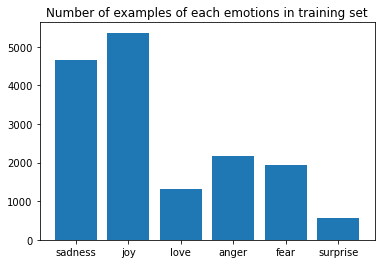

In [5]:
labels = train_data.features['label'].names
count = list(train_data_pd.iloc[:,1].value_counts().sort_index().to_numpy())
print(labels)
print(count)

plt.xticks(range(len(labels)),labels)
plt.bar(range(len(labels)), count)
plt.title("Number of examples of each emotions in training set")
plt.show()

In [82]:
from keras.preprocessing import sequence
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import Regularizer
import keras.utils as ku 
import numpy as np

In [92]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text']+test_data['text'])
total_words = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(train_data['text'])
x_test = tokenizer.texts_to_sequences(test_data['text'])

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

max_len = max([len(x) for x in x_test+x_train])

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

y_train = ku.to_categorical(train_data['label'], num_classes=6)
y_test = ku.to_categorical(test_data['label'], num_classes=6)

batch_size = 50
max_features = total_words = len(tokenizer.word_index) + 1
max_features

16000 train sequences
2000 test sequences
Pad sequences (samples x time)
x_train shape: (16000, 66)
x_test shape: (2000, 66)


16185

In [94]:
#lstm
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 50, input_length=66))
model.add(LSTM(50, dropout=0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test),
          callbacks=[ModelCheckpoint('model.{epoch:02d}.h5', monitor='val_acc',
                                     save_best_only=True, save_weights_only=True)])

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 66, 50)            809250    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 306       
Total params: 829,756
Trainable params: 829,756
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 16000 samples, validate on 2000 samples
Epoch 1/15
16000/16000 [==============================] - 34s 2ms/step - loss: 1.3765 - acc: 0.4662 - val_loss: 0.9427 - val_acc: 0.6930
Epoch 2/15
16000/16000 [==============================] - 31s 2ms/step - loss: 0.6487 - acc: 0.7839 - val_loss: 0.5893 - val_acc: 0.8080
Epoch 3/15
16000/16000 [=============================

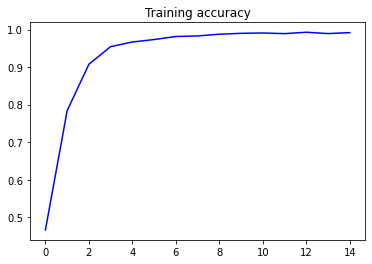

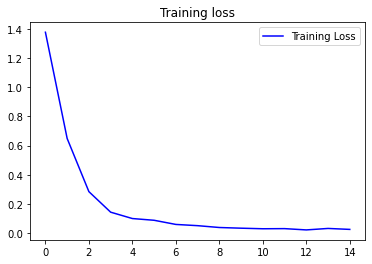

In [98]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [99]:
loss, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', loss)
print('Test accuracy:', acc)

2000/2000 [==============================] - 1s 252us/step
Test score: 0.32197414711117744
Test accuracy: 0.9139999926090241


In [100]:

# nlstm
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 50, input_length=66))
model.add(NestedLSTM(50, depth=2, dropout=0.2))
model.add(Dense(6, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test),
          callbacks=[ModelCheckpoint('model.{epoch:02d}.h5', monitor='val_acc',
                                     save_best_only=True, save_weights_only=True)])

#model.load_weights('model.15.h5')

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 66, 50)            809250    
_________________________________________________________________
nested_lstm_6 (NestedLSTM)   (None, 50)                40400     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 306       
Total params: 849,956
Trainable params: 849,956
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 16000 samples, validate on 2000 samples
Epoch 1/15
16000/16000 [==============================] - 100s 6ms/step - loss: 1.5495 - acc: 0.3706 - val_loss: 1.3986 - val_acc: 0.4845
Epoch 2/15
16000/16000 [==============================] - 110s 7ms/step - loss: 1.1377 - acc: 0.6034 - val_loss: 1.1378 - val_acc: 0.6085
Epoch 3/15
16000/16000 [===========================

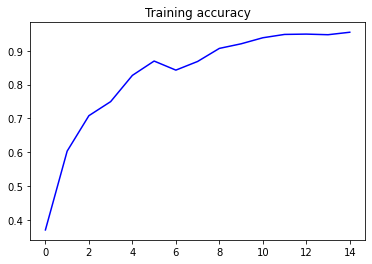

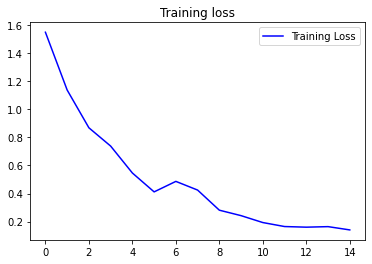

In [101]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [102]:
loss, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', loss)
print('Test accuracy:', acc)

2000/2000 [==============================] - 3s 1ms/step
Test score: 0.41732934564352037
Test accuracy: 0.871499989926815
